# The LHCb Masterclass explained 

For the outreach programme *LHCb Masterclass* students from secondary schools are invited to analyze a sample of $D^0 \to K^- \pi^+$ decays as collected from the LHCb experiment to measure the lifetime of the $D^0$ meson.

The data used for this exercise are public and can be obtained from the *Open Data* portal of CERN. 

In this tutorial we repeat the analysis designed for the LHCb Masterclass, using *Python* and *ROOT* in order to show how the most common operations in data analysis can be performed within such a framework.

We will take the opportunity to apply some *machine learning*, this is not part of the original excercise, but it is worth to include an example on how to use *Keras* and *Tensorflow* to separate signal and background. 
This is not a lecture on *machine learning*: several basic and important aspect of a machine learning problem are ignored here, for example we do not split the data in *training* and *test* samples. From a software perspective, it should be trivial to extend the example to include a more careful treatment of the neural network training and application. 

The website of the *LHCb International Masterclass*, where the excercise is shortly explained can be found at
[this link](http://lhcb-public.web.cern.ch/lhcb-public/en/LHCb-outreach/masterclasses/en/).
    

## Download the data

We obtain the data from the CERN *Open Data* portal: [opendata.cern.ch](http://opendata.cern.ch/record/401).

To download the data we use a bash command, starting with `!`.

`wget` followed by the address of the file to download. For `wget` to work, the file must be downloadable without authentication. 

We name the output `D02Kpi.root` to ensure the file is overwritten every time that we execute this notebook.

In [1]:
!wget http://opendata.cern.ch/record/401/files/MasterclassData.root -O D02Kpi.root

--2019-06-01 18:47:06--  http://opendata.cern.ch/record/401/files/MasterclassData.root
Resolving opendata.cern.ch (opendata.cern.ch)... 188.184.93.89, 188.184.28.138, 188.185.82.144, ...
Connecting to opendata.cern.ch (opendata.cern.ch)|188.184.93.89|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1289541 (1.2M) [application/octet-stream]
Saving to: ‘D02Kpi.root’

D02Kpi.root         100%[===================>]   1.23M  --.-KB/s    in 0.1s    

2019-06-01 18:47:06 (8.38 MB/s) - ‘D02Kpi.root’ saved [1289541/1289541]



## Understand the data

The downloaded ROOT file can be loaded in a pandas [DataFrame](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.html) which ease the access to the data via a *database-like* interface.

Using `describe()` we dump some statistics of the obtained dataset.

In [2]:
import root_pandas as rpd
dataset = rpd.read_root ( "D02Kpi.root" )

dataset.describe()

Welcome to JupyROOT 6.17/01


/usr/local/lib/python3.5/dist-packages/root_pandas/readwrite.py:320: FutureWarning: '.reindex_axis' is deprecated and will be removed in a future version. Use '.reindex' instead.
  df = df.reindex_axis(columns, axis=1, copy=False)


,D0_MINIP,D0_MINIPCHI2,D0_OWNPV_X,D0_OWNPV_Y,D0_OWNPV_Z,D0_OWNPV_XERR,D0_OWNPV_YERR,D0_OWNPV_ZERR,D0_OWNPV_CHI2,D0_OWNPV_NDOF,...,runNumber,eventNumber,BCID,BCType,OdinTCK,L0DUTCK,HLTTCK,GpsTime,Primaries,nPV
count,91583.0,91583.000000,91583.0,91583.0,91583.0,91583.0,91583.0,91583.0,91583.0,91583.0,...,91583.0,91583.0,91583.0,91583.0,91583.0,91583.0,91583.0,91583.0,91583.0,91583.0
mean,0.0,457.513062,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
std,0.0,6378.853027,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
min,0.0,0.000014,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
25%,0.0,2.124485,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
50%,0.0,6.298690,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
75%,0.0,27.436283,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
max,0.0,891711.062500,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


We see that there are several columms representing different variables of the $D^0$ meson and of its decay products `K^` and `\pi^+`. Most of them, however, are set to zero, probably for some policy of the LHCb experiment. Only the columns actually used in the excercise are available.

Let's try to identify the valid variables, those not masked, and let's plot them using `matplotlib`.

In [3]:
import numpy as np
import matplotlib.pyplot as plt

for variable in dataset.columns:
    try:
        if dataset[variable].mean() != 0. :
            with plt.xkcd():
                m, M = np.quantile(dataset[variable], [0.05,0.95])
                plt.figure()
                plt.hist (
                    dataset[variable], 
                    bins=np.linspace(m,M,20),
                    density=True
                    )
                plt.xlabel (variable)
                plt.ylabel ('Distribution')
                plt.draw()
                plt.show()
    except ValueError:
        pass


<Figure size 640x480 with 1 Axes>

<Figure size 640x480 with 1 Axes>

<Figure size 640x480 with 1 Axes>

<Figure size 640x480 with 1 Axes>

/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:6: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  


There are four variables available for the analysis. The most "structured" is `D0_MM` which represents the invariant mass of the $K^- \pi^+$ combinations. 

We identify immediately a peak centered at $\sim 1865 \mathrm{MeV}/c^2$, corresponding to the real decays $D^0 \to K^- \pi^+$. There is also a flat component which is due to the random combinations of a pion and a kaon of opposite charge, but not produced in a $D^0 \to K^- \pi^+$ decay. 

Let's try to study this variable in more detail.

#### Plotting with `matplotlib`

Plotting with `matplotlib` is extremely fast. We use it to quickly understand the data and produce figures on which we do not need complete control (which is achievable, but for which it is more difficult to obtain help within the HEP community).

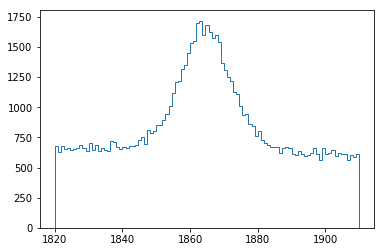

In [4]:
plt.hist ( dataset['D0_MM'].values, bins = np.linspace(1820,1910,100), histtype='step' )
plt.show()

#### Plotting with `ROOT`

The same plots can be obtained using `ROOT`, even if some additional lines are needed, using ROOT we access the same graphics library used in C++ since decades, and we are able to achieve an impressibe level of control on all the elements of the image.

To build the bridge between `numpy` or `pandas` and `ROOT` we use [root_numpy](http://scikit-hep.org/root_numpy/) and [root_pandas](http://scikit-hep.org/root_numpy/). 
While `root_pandas` allows to load and process the ROOT files with a python-friendly interface (as discussed above), `root_numpy` allows translate `TTree` and `THn*` objects into `numpy` arrays, and vice-versa.

Here, we will use [root_numpy.fill_hist](http://scikit-hep.org/root_numpy/reference/generated/root_numpy.fill_hist.html#root_numpy.fill_hist) to fill a `TH1D` object with the content of a `numpy.ndarray`.

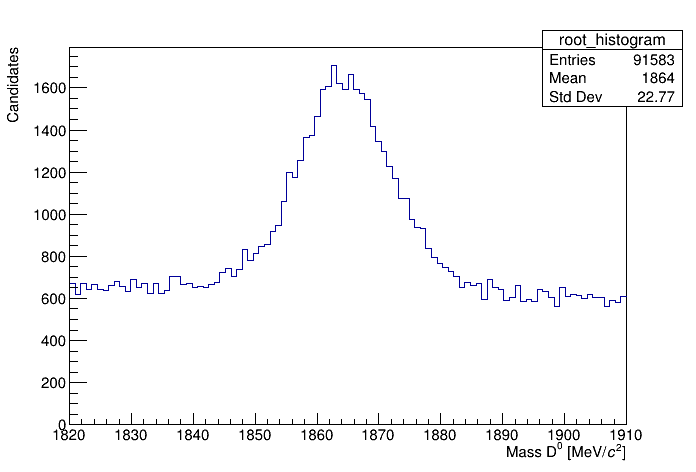

In [5]:
## Import the ROOT libraries
import ROOT 

## Create a Canvas object (the figure)
canvas = ROOT.TCanvas()

## Create a ROOT histogram, defining the binning, the title and the labels
root_histogram = ROOT.TH1D ( "root_histogram", ';Mass D^{0} [MeV/#it{c}^{2}]; Candidates', 100, 1820, 1910 )
root_histogram . SetMinimum ( 0 )

## Loads the root_numpy interface
import root_numpy as rnp 

## Fill the histogram
rnp.fill_hist ( root_histogram, dataset['D0_MM'] )

## Draw the histogram on the canvas and the canvas on the notebook.
root_histogram.Draw()
canvas.Draw()

## Model the data

Now that we are able to visualize the data, let's focus on the modelling. 
To build the data model for the invariant mass $m(K^- \pi^+)$ we will use `RooFit`, an extension of `ROOT` used providing an effective interface to describe complicated distributions and fitting them easily to the data.

Several other alternatives exist, but RooFit is a good balance between the generality of the distributions one can describe and the easiness in handling their normalizations during maximum likelihood fits. 

These are the usual steps of every RooFit program.

1. Convert the data in the RooFit format

In [6]:
m = ROOT.RooRealVar ('mass', 'D^{0} mass', 1820, 1910, "MeV/#it{c}^{2}")
datahist = ROOT.RooDataHist ( 'hist', 'hist', ROOT.RooArgList(m), root_histogram )


RooFit v3.60 -- Developed by Wouter Verkerke and David Kirkby 
                Copyright (C) 2000-2013 NIKHEF, University of California & Stanford University
                All rights reserved, please read http://roofit.sourceforge.net/license.txt



2. Define the variables to be left free to vary during the fit, include intializations and constraints

In [7]:
### Variables of the Gaussian peak
mean = ROOT.RooRealVar ( 'mean', 'sigma', 1860, 1850, 1890)
sigma = ROOT.RooRealVar ( 'sigma', 'sigma', 10, 1, 50 )

### Variables of the polynomial background
degree = 1
bkg_c = [ROOT.RooRealVar ( 'bkg_c%i'%i, 'bkg_c%i'%i, 0., -1., 1. ) for i in range(degree) ]

### Variables of the combination signal + background
nTot = root_histogram . GetSumOfWeights() 
nSig = ROOT.RooRealVar ( 'nSig', 'nSig', 0.5*nTot, 0, nTot )
nBkg = ROOT.RooRealVar ( 'nBkg', 'nBkg', 0.5*nTot, 0, nTot )

3. Define the model

In [8]:
peak = ROOT.RooGaussian ( 'gauss', 'gauss', m, mean, sigma )
bkg  = ROOT.RooChebychev ('bkg','bkg', m, ROOT.RooArgList(*bkg_c) )
pdf  = ROOT.RooAddPdf ( 'model', 'model', ROOT.RooArgList(peak, bkg), ROOT.RooArgList(nSig, nBkg) )

4. Fit the model to the imported histogram

In [9]:
pdf.fitTo ( datahist ) 

<ROOT.RooFitResult object at 0x(nil)>

[#1] INFO:Minization -- p.d.f. provides expected number of events, including extended term in likelihood.
[#1] INFO:Minization -- RooMinimizer::optimizeConst: activating const optimization
[#1] INFO:Minization --  The following expressions will be evaluated in cache-and-track mode: (gauss,bkg)
 **********
 **    1 **SET PRINT           1
 **********
 **********
 **    2 **SET NOGRAD
 **********
 PARAMETER DEFINITIONS:
    NO.   NAME         VALUE      STEP SIZE      LIMITS
     1 bkg_c0       0.00000e+00  2.00000e-01   -1.00000e+00  1.00000e+00
     2 mean         1.86000e+03  4.00000e+00    1.85000e+03  1.89000e+03
     3 nBkg         4.23400e+04  8.46800e+03    0.00000e+00  8.46800e+04
     4 nSig         4.23400e+04  8.46800e+03    0.00000e+00  8.46800e+04
     5 sigma        1.00000e+01  4.50000e+00    1.00000e+00  5.00000e+01
 **********
 **    3 **SET ERR         0.5
 **********
 **********
 **    4 **SET PRINT           1
 **********
 **********
 **    5 **SET STR           1
 *

5. Draw the result

[#1] INFO:Plotting -- RooAbsPdf::plotOn(model) directly selected PDF components: (bkg)
[#1] INFO:Plotting -- RooAbsPdf::plotOn(model) indirectly selected PDF components: ()


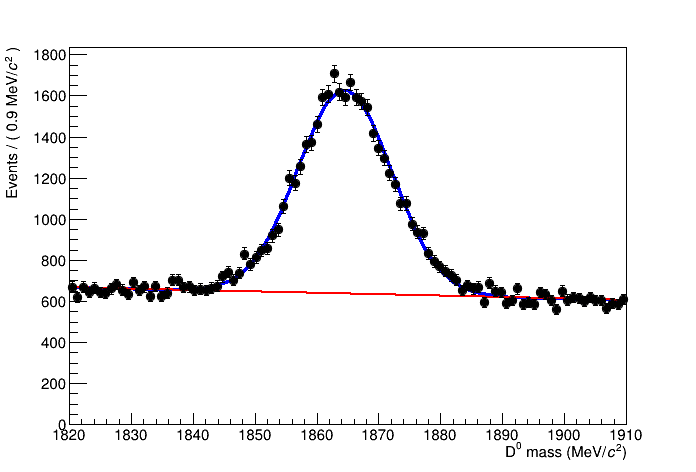

In [10]:
canvas = ROOT.TCanvas()
ROOT.gStyle.SetOptTitle(0)
frame = m.frame()
datahist.plotOn ( frame )
pdf.plotOn ( frame )
pdf.plotOn ( frame, ROOT.RooFit.Components ('bkg'), ROOT.RooFit.LineWidth(2), ROOT.RooFit.LineColor(ROOT.kRed) )
datahist.plotOn ( frame )

frame.Draw()
canvas.Draw()

## Learn from the data

Once we have a statistical model for the data, we can try to describe each entry with its probability of belonging to the class *Signal* or *Background*. 

To achieve this result without looping on all the entries of the dataset, which could be extremely long, given the slow *Python* interpretation, we sample the probability of being *Signal* and *Background* for hundred equidistant values of $m(K^- \pi^+)$ and then we interpolate using the low-level C APIs of `numpy`.

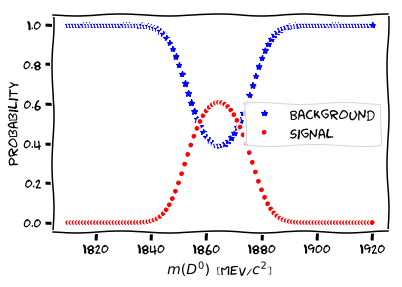

In [11]:
masses = np.linspace ( 1810, 1920, 100 )
sigProb = []; bkgProb = []

nSig_ = nSig.getVal()
nBkg_ = nBkg.getVal()

for mass in masses:
    m.setVal ( mass )
    s = nSig_ * peak.getVal(ROOT.RooArgSet(m))
    b = nBkg_ * bkg.getVal(ROOT.RooArgSet(m))
    sigProb.append (s/(s+b))
    bkgProb.append (b/(s+b))

dataset['w_sig'] = np.interp ( dataset['D0_MM'], masses, sigProb )
dataset['w_bkg'] = np.interp ( dataset['D0_MM'], masses, bkgProb )

with plt.xkcd():
    plt.plot ( masses, bkgProb, '*b', label='Background')
    plt.plot ( masses, sigProb, '.r', label='Signal')
    plt.xlabel ( '$m(D^0)$ [MeV/$c^2$]')
    plt.ylabel ( 'Probability' )
    plt.legend()
    plt.show()

As a sanity-check that these probabilities make sense, let's weight every decay candidate by its probability of belonging to the signal or to background categories while filling a histogram. 

We expect to observe the signal peak shifted to the baseline of the histogram in the first case, or to completely disappear when weighing by the background category.

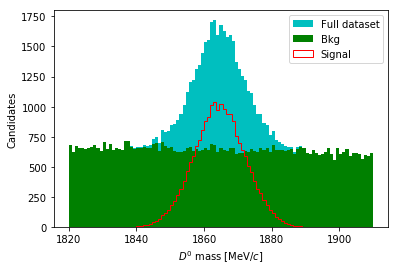

In [12]:
plt.hist (dataset['D0_MM'], bins=np.linspace(1820,1910,100), color='c', label='Full dataset')
plt.hist (dataset['D0_MM'], bins=np.linspace(1820,1910,100), weights=dataset['w_bkg'], color = 'g', label='Bkg')
plt.hist (dataset['D0_MM'], bins=np.linspace(1820,1910,100), weights=dataset['w_sig'], histtype='step', color='r', label='Signal')
plt.xlabel ('$D^0$ mass [MeV/$c$]')
plt.ylabel ('Candidates')
plt.legend()
plt.show()

### From the probability to the background-subtraction by weighting

Now that we know the probability that an event belongs to the *Signal* or *Background* category, we can try to define a *weight* that subtracts the background contribution whatever other variable we display. 
To define this weight, we need to make assumptions on the relation between this *other variable*, say $y$ and the variable that we have used to measure the by-event probability, say $x$. 

If the two variables are totally correlated, $y = f(x)$, then the probability defined for $x$ is valid also for $y$ (obviously...).
If the two variables are totally uncorrelated, *i.e.* we can write that the probability densities $pdf(x,y) = pdf_x(x) * pdf_y(y)$, then the weight that we need is the [$_s$Weight](https://arxiv.org/abs/physics/0402083).

We use the package `hep_ml` to load compute the sWeight in a purely python way.

In [13]:
from hep_ml.splot import compute_sweights
weights = compute_sweights ( dataset[['w_sig','w_bkg']])
dataset [['sW_sig', 'sW_bkg']] = (weights)

The $_s$Weight has some important properties:
1. It is a function of the mass

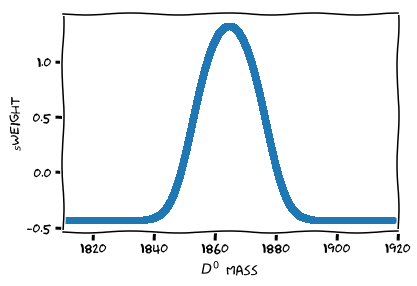

In [14]:
with plt.xkcd():
    plt.scatter( dataset['D0_MM'], dataset['sW_sig'])
    plt.xlim(1810,1920)
    plt.xlabel ('$D^0$ Mass')
    plt.ylabel ('$_s$Weight')
    plt.show()

2. It can be negative where the events must be used to statistically subtract the background

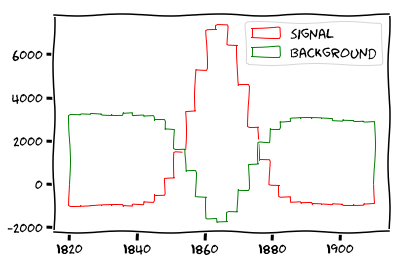

In [15]:
with plt.xkcd():    
    plt.hist (dataset['D0_MM'], bins=np.linspace(1820,1910,30), weights=dataset['sW_sig'], histtype='step', color='r', label='signal')
    plt.hist (dataset['D0_MM'], bins=np.linspace(1820,1910,30), weights=dataset['sW_bkg'], histtype='step', color='g', label='background')
    plt.legend()
    plt.show()

3. The sum of the sWeights is equal to the sum of the probabilities, which by constraction are equal to the number of signal and background events obtained with the fit. Note a small discrepancy between the number of background events from the fit and the sum over the background probabilities due to the slightly cropped mass range used to perform the fit.

In [16]:
import pandas as pd
table = pd.DataFrame(columns=['result'])
operations = {
    "Sum of signal sWeights": np.sum(dataset['sW_sig']),
    "Sum of background sWeights": np.sum(dataset['sW_bkg']),
    "Sum of signal probabilities": np.sum(dataset['w_sig']),
    "Sum of background probabilities": np.sum(dataset['w_bkg']),
    "Signal events from fit": nSig.getVal(),
    "Background events from fit": nBkg.getVal(),

}
for op, res in operations.items(): table.loc[op] = [res]

table

,result
Sum of background probabilities,70582.110370
Signal events from fit,21005.648427
Sum of signal sWeights,21000.889630
Background events from fit,63674.549258
Sum of signal probabilities,21000.889630
Sum of background sWeights,70582.110370


## Learn from the data, using Keras

Now that we have the $_s$Weights, let's try to use them to improve the signal-vs-background separation.

We will use a preprocessor that has been developed by people in Florence and which is not part of the official releases. So let's download it using pip.

In [17]:
!pip install --user --upgrade FastQuantileLayer    

Requirement already up-to-date: FastQuantileLayer in /BIG/LOCAL/home/anderlini/.local/lib/python3.5/site-packages (0.2)


Let's import the packages that we need: `tensorflow` to describe and run the neural network, `tqdm` to keep track of the timing and the newly installed `FastQuantileLayer` to transform the input variables into normally distributed inputs.

In [18]:
import tensorflow as tf
tf.reset_default_graph()

from tqdm import tnrange
from FastQuantileLayer import FastQuantileLayer 

Let's create a tensor containing the input variables that we plan to use

In [19]:
inputvars = dataset[['D0_MINIPCHI2', 'D0_TAU', 'D0_PT']].values

Let's define the input variables. These are `placeholder`s within the tensorflow graph, because we will need to replace them with part (or all) the dataset during the training.

In [20]:
dataIn = tf.placeholder ( tf.float32 , shape = (None, inputvars.shape[1] ), name = 'dataIn' )
p_sig  = tf.placeholder ( tf.float32 , shape = (None,), name = 'p_sig' )
p_bkg  = tf.placeholder ( tf.float32 , shape = (None,), name = 'p_bkg' )

Let's define the neural network model, a simple shallow neural network with 256 nodes is more than enough for this simple task. 

In [21]:
model = tf.keras.models.Sequential ()
model . add ( FastQuantileLayer(output_distribution='normal').fit ( inputvars ) )
model . add ( tf.keras.layers.Dense ( 256, activation='relu', kernel_initializer='he_normal' ) )
#model . add ( tf.keras.layers.LeakyReLU ( 0.2 ) )
model . add ( tf.keras.layers.Dense ( 1, activation = 'sigmoid' ) )

Let's define the *loss* function, using a modified *cross-entropy* definition

In [22]:
y_hat = model ( dataIn ) [:,0]
loss = -tf.reduce_mean ( tf.log ( y_hat ) * p_sig  + tf.log(1. - y_hat)*p_bkg )  #  cross-entropy

Instructions for updating:
Colocations handled automatically by placer.


And then let's define the optimizer, we will use the customary [`AdamOptimizer`](https://www.tensorflow.org/api_docs/python/tf/train/AdamOptimizer) with enhanced stability once the minimum is reached. 

In [23]:
minimize = tf.train.AdamOptimizer ( 0.001, beta1=0.5, epsilon=0.001 ).minimize ( loss )

Finally, we are ready to train the neural network.

In [24]:
nEpochs = 100
batchsize = 10000
losses = []
with tf.Session() as ss:
    ss.run ( tf.global_variables_initializer() )
    progressBar = tnrange ( nEpochs )
    for iEpoch in progressBar:
        indices = np.random.permutation ( len (dataset) ) [:batchsize]
        feed_dict = {
            dataIn : inputvars,#[indices],
            p_sig  : dataset['w_sig'].values,
            p_bkg  : dataset['w_bkg'].values,
        }
        
        _, loss_, y_hat_ = ss.run ((minimize, loss, y_hat), feed_dict = feed_dict)
        progressBar . set_description ( "%.3f" % loss_ )

        losses . append ( loss_ )
    dataset['signalNN'] = model.predict(inputvars)

2019-06-01 18:47:29.482412: I tensorflow/core/platform/profile_utils/cpu_utils.cc:94] CPU Frequency: 2600160000 Hz
2019-06-01 18:47:29.487572: I tensorflow/compiler/xla/service/service.cc:150] XLA service 0x56458592c000 executing computations on platform Host. Devices:
2019-06-01 18:47:29.487644: I tensorflow/compiler/xla/service/service.cc:158]   StreamExecutor device (0): <undefined>, <undefined>


Let's consider the evolution of the loss function:

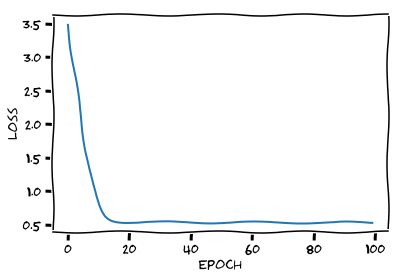

In [25]:
with plt.xkcd():
    plt.plot ( losses )
    plt.xlabel ('Epoch')
    plt.ylabel ('Loss')
    plt.show()
        

And the distribution of the output of the neural network. Large values indicate higher confidence towards the *Signal* hypothesis.

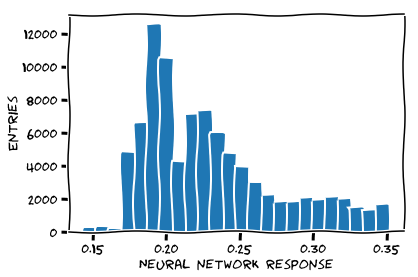

In [26]:
with plt.xkcd():
    nn = dataset['signalNN']
    nn_min, nn_max = np.quantile(nn,[0.01,0.99])
    plt.hist(nn, bins=np.linspace(nn_min,nn_max,25))
    plt.xlabel ('Neural network response')
    plt.ylabel ('Entries')
    plt.show()


## Apply the neural network to the data

Once the neural network is trained, we can apply it to the data to enhance the signal purity. 

To have an idea of the effect of the application of the neural network let's superpose the histograms obtained cutting at several thresholds.

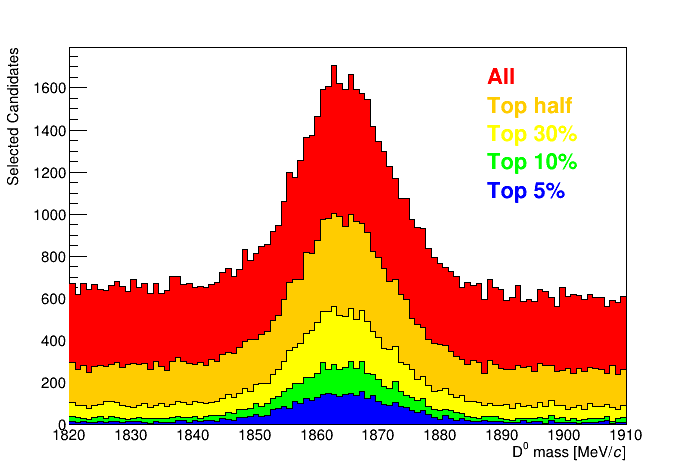

In [27]:
h_m = ROOT.TH1D ('h_m', ';D^{0} mass [MeV/#it{c}]; Selected Candidates', 100, 1820,1910)
ROOT.gStyle.SetOptStat ( 0 )
selected_hists = list()
latexLabels = list()

thresholds = np.quantile ( dataset['signalNN'], [0.,0.5, 0.78, 0.90, 0.95] )
labels =  iter(['All', 'Top half', 'Top 30%', 'Top 10%', 'Top 5%'])

colors = iter(['Red','Orange','Yellow','Green','Blue'])

for threshold in thresholds:
    selected_hists . append ( h_m.Clone('h%.2f'%threshold) )
    h = selected_hists[-1]
    rnp.fill_hist ( h, dataset['D0_MM'].where(dataset['signalNN']>threshold) )
    h . SetFillColor ( getattr(ROOT, 'k'+next(colors)) )
    h . SetFillStyle ( 1000 )
    h . SetLineColor ( ROOT.kBlack )
    h . SetMinimum ( 0 )
    
    
selected_hists [0].Draw ( "AXIS" )

labelx, labely = 0.7, 0.82
latex = ROOT.TLatex(); latex.SetNDC()
for l, h in zip(labels,selected_hists):
    h.Draw ( "HISTOSAME" )
    latex.SetTextColor ( h.GetFillColor() )
    latexLabels.append (latex.DrawLatex (labelx, labely, l))
    labely -= 0.06

canvas.Draw()

On this dataset, the effect of the neural network is not that exciting.

Let's draw the usual ROC (Receiver-Operator Charcteristic) curve to represent the effect.

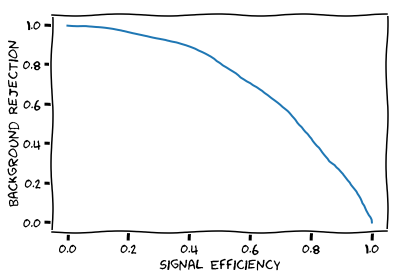

In [28]:
thresholds = np.quantile ( dataset['signalNN'], np.linspace(0,1,100))
effSig = list(); effBkg = list()
for threshold in thresholds:
    effSig . append (np.sum(dataset['sW_sig'].where(dataset['signalNN']>threshold))/np.sum(dataset['sW_sig']))
    effBkg . append (np.sum(dataset['sW_bkg'].where(dataset['signalNN']>threshold))/np.sum(dataset['sW_bkg']))

with plt.xkcd():
    plt.plot ( effSig, 1. - np.array(effBkg) )
    plt.xlabel ('Signal Efficiency')
    plt.ylabel ('Background Rejection')
    plt.show()
    

Given the ROC curve, combined with the total number of signal and background events in the original samples to define the optimal cut to enhance the statistical significance.

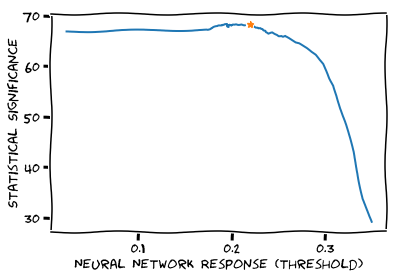

In [35]:
significances = list()
totSig = np.sum(dataset['sW_sig'])
totBkg = 1.1*np.sum(dataset['sW_bkg'])
for es, eb in zip (effSig, effBkg):
    significances . append ( totSig*es / np.sqrt(totSig*es+totBkg*eb+1))

significances = np.array ( significances )
best_threshold = thresholds [ np.argmax ( significances ) ]

cut = significances > significances.max()/3.
with plt.xkcd():
    plt.plot(thresholds[cut], significances[cut])
    plt.plot ([best_threshold], [np.max(significances)], '*')
    plt.xlabel("Neural Network Response (threshold)")
    plt.ylabel("Statistical Significance")
    plt.show()

## Measure the $D^0$ lifetime

We are now ready to use this data sample to measure the lifetime of the $D^0$ meson. As a simple $\chi^2$ fit to the decay time histogram.

In [36]:
h_tau = ROOT.TH1D ('h_tau', ';D^{0} decay time [ps]; Background-subtracted candidates', 100, 0.150, 10.15)
h_tau . SetMarkerColor (ROOT.kBlack)
h_tau . SetLineColor (ROOT.kBlack)
h_tau . SetMarkerStyle (20)
h_tau . SetMarkerSize (0.7)
cut = dataset['D0_PT']>1500
rnp.fill_hist ( h_tau, dataset['D0_TAU'].where(cut)*1e3, dataset['sW_sig'].where(cut) )
h_tau.Fit('expo', 'QLE', 'E1')
slope = h_tau.GetFunction('expo').GetParameter(1)
slopeError = h_tau.GetFunction('expo').GetParError(1)

tau = -1. / slope
tauError = 1. / slope ** 2 * slopeError

Let's compare the result with the value obtained by the [Particle Data Group (pdg)](http://pdg.lbl.gov).  

Instead of accessing the [dedicated web page](http://pdglive.lbl.gov/DataBlock.action?node=S032T&home=MXXX035), we use the Python API to learn a new thing.

In [31]:
from particle import Particle, width_to_lifetime
from hepunits import ns, ps
D0 = Particle.find ('D0')
pdg_tau = width_to_lifetime ( D0.width )
pdg_tauError = (width_to_lifetime ( D0.width - D0.width_lower )  - pdg_tau )
pdg_tau *= ns/ps
pdg_tauError *= ns/ps
print(D0.describe())

Name: D0             ID: 421          Latex: $D^{0}$
Mass  = 1864.83 ± 0.05 MeV
Lifetime = 4.101e-04 ± 1.5e-06 ns
Q (charge)        = 0       J (total angular) = 0.0      P (space parity) = -
C (charge parity) = ?       I (isospin)       = 1/2      G (G-parity)     = ?
    SpinType: SpinType.PseudoScalar
    Quarks: cU
    Antiparticle name: D~0 (antiparticle status: Barred)


Finally, we draw the histogram with the superposed exponential function.

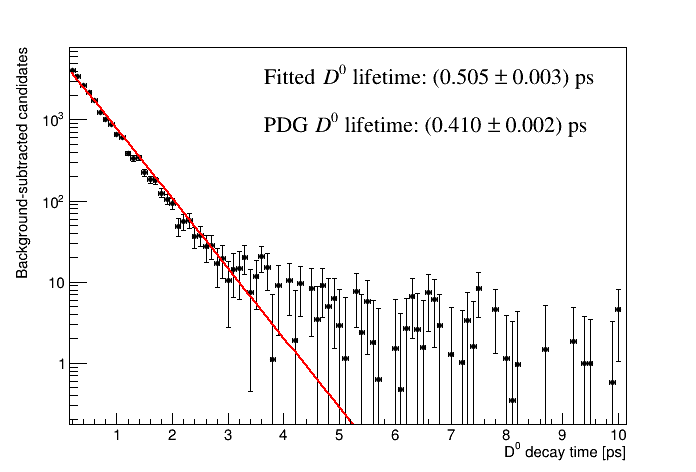

In [32]:
latex = ROOT.TLatex(); latex.SetNDC()
latex . SetTextFont (132)
latex.DrawLatex ( 0.38, 0.82, "Fitted #it{D}^{0} lifetime: (%.3f #pm %.3f) ps" % (tau, tauError) )
latex.DrawLatex ( 0.38, 0.72, "PDG #it{D}^{0} lifetime: (%.3f #pm %.3f) ps" % (pdg_tau, pdg_tauError) )
canvas.SetLogy()
canvas.Draw()

## Assess the systematic uncertainties due to the selection
Puzzled by the too large value of the result (and also because an important bias towards larger lifetimes is evident from the plot) we move to assess the systematic uncertainties affecting this measurement.

We repeat the fit procedure for several, different, values of the maximum of the $D^0$ impact parameter, which measures how the $D^0$ flight direction inferred from the momenta of the kaon and the pion, is consistent with the *primary vertex*, where the collision of the two protons happened.

Warning in <TROOT::Append>: Replacing existing TH1: h_tau (Potential memory leak).


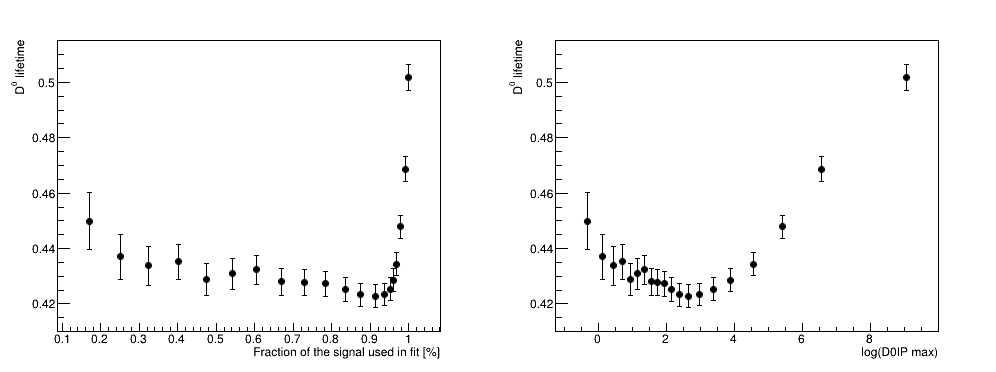

In [33]:
best_threshold = 0
cutPT = dataset['D0_PT'] > 3500

D0IP_thresholds = np.quantile (dataset['D0_MINIPCHI2'], np.linspace(0.1,0.99,20))
fitted_lifetime = list()
fitted_lifetime_error = list()

import pandas as pd

lifetimeDB = pd.DataFrame(columns=['D0IPmax','sigEff','tau', 'error'])

for D0IP_threshold in D0IP_thresholds:
    h_tau = ROOT.TH1D ('h_tau', ';D^{0} decay time [ps]; Background-subtracted candidates', 100, 0.150, 10.15)
    cutIP = (dataset['D0_MINIPCHI2'] < D0IP_threshold )
    rnp.fill_hist ( h_tau, dataset['D0_TAU'].where(cutPT&cutIP)*1e3, dataset['sW_sig'].where(cutPT&cutIP) )
    sigEff = np.sum ( dataset['sW_sig'].where(cutPT&cutIP) ) / np.sum ( dataset['sW_sig'].where(cutPT) ) 
    if h_tau.GetSumOfWeights() < 1: continue
    h_tau.Fit('expo', 'QLE', 'E1')
    slope = h_tau.GetFunction('expo').GetParameter(1)
    slopeError = h_tau.GetFunction('expo').GetParError(1)
    h_tau.Delete()
    lifetimeDB.loc[len(lifetimeDB)] = [D0IP_threshold, sigEff, -1. / slope,  1. / slope ** 2 * slopeError]


    
g = ROOT.TGraphErrors (len(lifetimeDB),
                       lifetimeDB['sigEff'].values, lifetimeDB['tau'].values,
                       lifetimeDB['sigEff'].values*0., lifetimeDB['error'].values,
                      )

g . SetTitle ("Lifetime bias; Fraction of the signal used in fit [%]; D^{0} lifetime")
g.SetMarkerStyle(20)
g.SetMarkerSize (0.8)

g2 = ROOT.TGraphErrors (len(lifetimeDB),
                       np.log(lifetimeDB['D0IPmax'].values), lifetimeDB['tau'].values,
                       lifetimeDB['sigEff'].values*0., lifetimeDB['error'].values,
                      )

g2 . SetTitle ("Lifetime bias as a function of the detachment threshold; log(D0IP max); D^{0} lifetime")
g2.SetMarkerStyle(20)
g2.SetMarkerSize (0.8)

canvas = ROOT.TCanvas ( "c2", "c2", 1000, 400 )
canvas.Divide(2,1)
canvas.cd(1)
g.Draw('AP')
canvas.cd(2)
g2.Draw('AP')


canvas.SetLogy(False)
canvas.Draw()

We observe a clear effect at large impact parameters, *i.e.* for poor consistency between the $D^0$ flight direction and the position of the primary vertex. 

We know that this effect is due to the production of $D^0$ mesons in $b$-hadron decays. Since the $b$-hadrons have a lifetime of the order of 1.6 ns, they fly away from the production vertex and then decay producing a $D^0$. 
Such a $D^0$ will not be consistent with being produced in the $pp$ collision, and its decay vertex will be statistically much further than it is for $D^0$ hadrons produced directly in the $pp$ collision. 

This bias has to be taken into account when measuring the lifetime. We could build a more complicated fit model, for example studying the contribution from this background with simulation, or we could try to cut harder and harder on the consistency between the reconstructed $D^0$ momentum and the primary vertex. Such a selection reduce the statistical power of the measurement, but studying the trend we may try to assess and correct the systematic uncertainty.

## Conclusion

We discussed the excercise proposed for the LHCb International Masterclass describing and showing in detail all of the statistical and analysis steps hidden behind the Graphical User Interface usually provided to the students. 

We hope that this excercise will also represent a useful reference to preform some of the most common steps in the HEP-data analysis.

We will extend this example and create new ones in the future to build a code base useful to enhance the productivity of everyone, especially of students and young post-docs.